In [85]:
%pylab inline
import pandas as pd
import numpy as np
#import pandana as pdna
import os, glob
drop=os.getenv('DROPBOX_LOC')
                               
pd.options.display.float_format = '{:,.0f}'.format
pd.options.display.mpl_style = 'default'

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


## Compare county-level `TOTHH`, `TOTEMP` levels from TAZ files, juris files

In [48]:
## define geographic mappings

bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

bayarearegionsmtc={4:'Alameda',#East Bay',
 5:'Contra Costa',#East Bay',
 3:'Santa Clara',#South Bay',
 7:'Napa',#North Bay',
 2:'San Mateo',#West Bay',
 1:'San Francisco',#West Bay',
 8:'Sonoma',#North Bay',
 9:'Marin',#'West Bay',
 6:'Solano'}#'North Bay'}

In [49]:
## load a relationship file between places and counties

places_to_counties = pd.read_csv('http://www2.census.gov/geo/docs/reference/codes/files/st06_ca_places.txt',sep='|',header=0,
                                 names=['ST','FIPS','place','placename','type','asdf','county'],dtype=object)
places_to_counties['geoid']='1600000US06'+places_to_counties.place
places_to_counties['county']=places_to_counties.county.str.replace(' County','')
places_to_counties['place']=places_to_counties.placename.str.replace(' city| town','')
places_to_counties=places_to_counties.loc[(places_to_counties.county.isin(bayareafips_full.values()))&(places_to_counties.type=='Incorporated Place')]

## check a city
places_to_counties[places_to_counties.placename.str.contains('Redwood')]

,ST,FIPS,place,placename,type,asdf,county,geoid
1116,CA,06,Redwood City,Redwood City city,Incorporated Place,A,San Mateo,1600000US0660102


In [51]:
## local file paths
pthtaz=os.path.join(drop,'Documents/Data/Urbansim/urbansim2/pba2040official/run7224c*')
pthjuris=os.path.join(drop,'Documents/Data/Urbansim/urbansim2/pba2040official/run7224_juris*')

### TAZ file processing

In [52]:
## enumerate taz files
files = glob.glob(pthtaz)
files

['C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_baseyear_taz_summaries_2010.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2015.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2020.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2025.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2030.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2035.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224c_taz_summaries_2040.csv']

In [53]:
## load taz files
import re
out={}
for f in files:
    print f
    yr=re.search('(?<=summaries_)\d{4}',f).group()
    print yr
    temp=pd.read_csv(f)
    out[yr]=temp

C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_baseyear_taz_summaries_2010.csv
2010
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2015.csv
2015
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2020.csv
2020
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2025.csv
2025
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2030.csv
2030
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2035.csv
2035
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224c_taz_summaries_2040.csv
2040


In [54]:
## prep taz data in long format for comparing with jurisdiction-file summaries

tazs=pd.concat(out).reset_index().rename(columns={'level_0':'year','level_1':'rowid'})
tazs=tazs.rename(columns=lambda x: x.lower())
tazs['county']=tazs.county.map(bayarearegionsmtc)
tazs= tazs.set_index(['year','county','zone'])[[u'tothh', u'mfdu', u'sfdu',u'totpop',u'hhpop',u'gqpop',  u'empres',
       u'age0004', u'age0519', u'age2044', u'age4564', u'age65p', u'totemp', u'agrempn',
       u'fpsempn', u'herempn', u'retempn',  u'mwtempn', u'othempn',
       u'hhincq1', u'hhincq2', u'hhincq3', u'hhincq4', u'shpop62p', 
       u'ciacre_unweighted', u'resacre_unweighted',
       u'ciacre', u'resacre', u'totacre']]

topvars=['tothh','totemp']

taz_county_summary = tazs.sum(level=['year','county'])[topvars].stack().reset_index(name='value').\
rename(columns={'level_2':'variable'}).set_index(['county','year','variable']).value
taz_county_summary.name='taz 7224c'
taz_county_summary.head()

county        year  variable
Alameda       2010  tothh      545,017
                    totemp     705,689
Contra Costa  2010  tothh      375,387
                    totemp     360,080
Marin         2010  tothh      103,208
Name: taz 7224c, dtype: float64

### Jurisdiction files processing

In [55]:
## enumerate files--and replace the 2010 one with the actual pre-run 2010 baseyear
filesjuris = glob.glob(pthjuris)
del filesjuris[0]
filesjuris.append(r'C:\Users\akselo\Dropbox\Documents\Data\Urbansim\urbansim2\pba2040official\run7224_baseyear_juris_summaries_2010.csv')
filesjuris

['C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2015.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2020.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2025.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2030.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2035.csv',
 'C:\\Users\\Akselo\\Dropbox\\Documents/Data/Urbansim/urbansim2/pba2040official\\run7224_juris_summaries_2040.csv',
 'C:\\Users\\akselo\\Dropbox\\Documents\\Data\\Urbansim\\urbansim2\\pba2040official\\run7224_baseyear_juris_summaries_2010.csv']

In [56]:
## load the files

import re
outjuris={}
for f in filesjuris:
    print f
    yr=re.search('(?<=summaries_)\d{4}',f).group()
    print yr
    tempjuris=pd.read_csv(f)
    outjuris[yr]=tempjuris

outjuris=pd.concat(outjuris)

C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2015.csv
2015
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2020.csv
2020
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2025.csv
2025
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2030.csv
2030
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2035.csv
2035
C:\Users\Akselo\Dropbox\Documents/Data/Urbansim/urbansim2/pba2040official\run7224_juris_summaries_2040.csv
2040
C:\Users\akselo\Dropbox\Documents\Data\Urbansim\urbansim2\pba2040official\run7224_baseyear_juris_summaries_2010.csv
2010


In [57]:
## basic processing

jurisdata=outjuris.reset_index().rename(columns={'level_0':'year'})
jurisdata['source']='juris 7224'
jurisdata['county']=jurisdata.juris.map(places_to_counties.set_index('place').county)
jurisdata.loc[jurisdata.juris.str.contains(' County'),'county']=jurisdata.loc[jurisdata.juris.str.contains(' County'),'juris'].str.replace(' County','')
jurisdata.loc[jurisdata.juris.str.contains(' County'),'juris']='Unincorporated'
jurisdata['year']=jurisdata['year'].astype(str)
jurisdata=jurisdata.set_index(['source','county','juris','year'])[['tothh','totemp']]
jurisdata_county=jurisdata.sum(level=['county','year']).stack()
jurisdata_county.index=jurisdata_county.index.set_names('variable',level=2)
jurisdata_county.name='juris 7224'
jurisdata_county.head()

county   year  variable
Alameda  2010  tothh       545138
               totemp      705542
         2015  tothh       585475
               totemp      834229
         2020  tothh       614965
Name: juris 7224, dtype: int64

In [59]:
taz_v_juris_countylevel = pd.concat([jurisdata_county,taz_county_summary],axis=1)
taz_v_juris_countylevel=taz_v_juris_countylevel.stack().reset_index(name='value').rename(columns={'level_3':'source'})
taz_v_juris_countylevel#.to_csv(os.path.join(drop,'Data/pba2040_compare_jurisdata_to_tazdata_countylevel.csv'))

,county,year,variable,source,value
0,Alameda,2010,totemp,juris 7224,"705,542"
1,Alameda,2010,totemp,taz 7224c,"705,689"
2,Alameda,2010,tothh,juris 7224,"545,138"
3,Alameda,2010,tothh,taz 7224c,"545,017"
4,Alameda,2015,totemp,juris 7224,"834,229"
5,Alameda,2015,totemp,taz 7224c,"829,055"
6,Alameda,2015,tothh,juris 7224,"585,475"
7,Alameda,2015,tothh,taz 7224c,"585,347"
8,Alameda,2020,totemp,juris 7224,"858,683"
9,Alameda,2020,totemp,taz 7224c,"850,637"


## plotting 

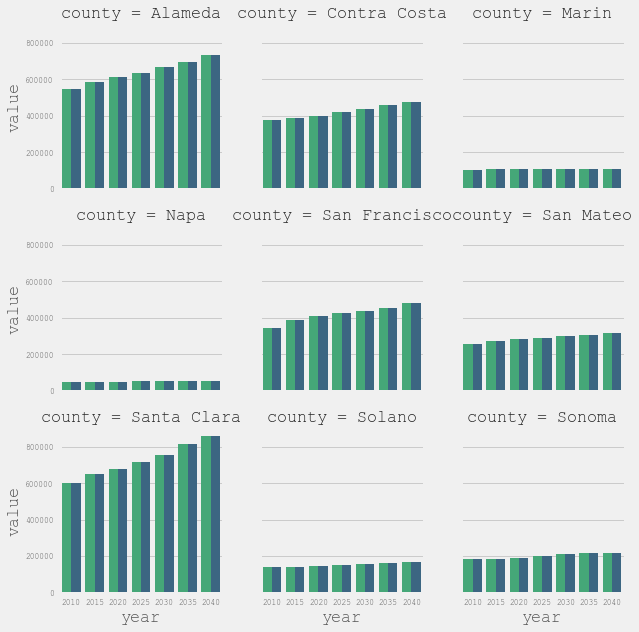

In [86]:
## TOTHH

g = sns.FacetGrid(taz_v_juris_countylevel[taz_v_juris_countylevel.variable=='tothh'], col='county', margin_titles=True,col_wrap=3)
ax = g.map(sns.barplot, 'year','value','source', ci=False, palette=sns.color_palette("viridis_r", n_colors=2))

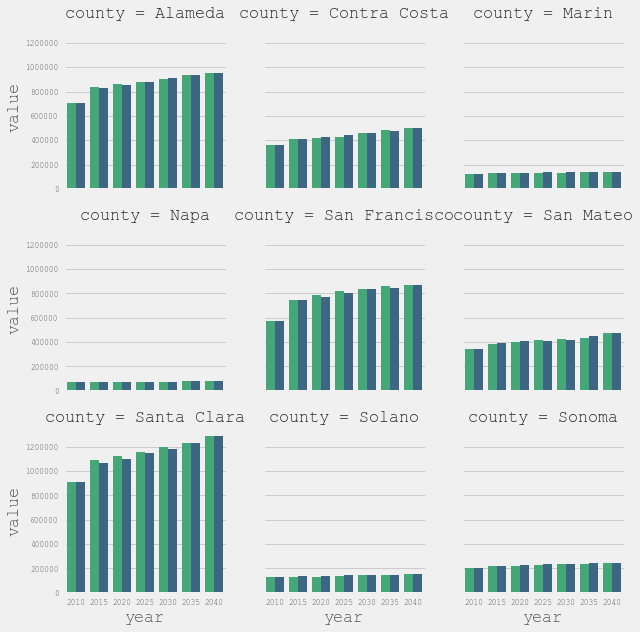

In [87]:
## TOTEMP

g = sns.FacetGrid(taz_v_juris_countylevel[taz_v_juris_countylevel.variable=='totemp'], col='county', margin_titles=True,col_wrap=3)
ax = g.map(sns.barplot, 'year','value','source', ci=False, palette=sns.color_palette("viridis_r", n_colors=2))